In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from tqdm import tqdm


train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

train.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

In [3]:
from sklearn.covariance import GraphicalLasso

def get_mean_cov(x,y):
    model = GraphicalLasso(max_iter=100)
    ones = (y==1).astype(bool)
    x2 = x[ones]
    model.fit(x2)
    p1 = model.precision_
    m1 = model.location_
    
    onesb = (y==0).astype(bool)
    x2b = x[onesb]
    model.fit(x2b)
    p2 = model.precision_
    m2 = model.location_
    
    ms = np.stack([m1,m2])
    ps = np.stack([p1,p2])
    return ms,ps

In [4]:
# INITIALIZE VARIABLES
cols = [c for c in train.columns if c not in ['id', 'target']]
cols.remove('wheezy-copper-turtle-magic')
oof = np.zeros(len(train))
preds = np.zeros(len(test))

# BUILD 512 SEPARATE MODELS
for i in range(512):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
    
    # STRATIFIED K-FOLD
    skf = StratifiedKFold(n_splits=51, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3, train2['target']):
        
        # MODEL AND PREDICT WITH QDA
        clf = QuadraticDiscriminantAnalysis(reg_param=0.5)
        clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof[idx1[test_index]] = clf.predict_proba(train3[test_index,:])[:,1]
        preds[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits
       
    #if i%64==0: print(i)
        
# PRINT CV AUC
auc = roc_auc_score(train['target'],oof)
print('QDA scores CV =',round(auc,5))

QDA scores CV = 0.96629


In [5]:

clfs = [KNeighborsClassifier(n_neighbors = 11, weights = 'distance', p = 2, metric = 'minkowski'),
        QuadraticDiscriminantAnalysis(reg_param=0.6),
        SVC(probability=True,kernel='poly',degree=4,gamma='auto')]
names = ['KNN', 'QDA', 'SVC', 'GaussianMixture']


# clfs = [QuadraticDiscriminantAnalysis(reg_param=0.6)]
# names = ['QDA']


# names = ['GaussianMixture']

test['target'] = preds

train_target = train['target'].copy()

#flip label
# train.loc[oof > 0.99, 'target'] = 1
# train.loc[oof < 0.09, 'target'] = 0

d = 0.01
# for d in [0.011, 0.013, 0.015, 0.017, 0.019]:

# INITIALIZE VARIABLES


scores = [{'oof' : np.zeros(len(train)), 'preds' : np.zeros(len(test))} for clf in names]



# BUILD 512 SEPARATE MODELS
for k in tqdm(range(512)):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==k] 
    train2p = train2.copy(); idx1 = train2.index 
    test2 = test[test['wheezy-copper-turtle-magic']==k]

    # ADD PSEUDO LABELED DATA
    test2p = test2[ (test2['target']<=d) | (test2['target']>=1 - d) ].copy()
    test2p.loc[ test2p['target']>=0.5, 'target' ] = 1
    test2p.loc[ test2p['target']<0.5, 'target' ] = 0 
    
    
    train2p = pd.concat([train2p,test2p],axis=0)
    train2p.reset_index(drop=True,inplace=True)

    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=2).fit(train2p[cols])     
    train3p = sel.transform(train2p[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])

    # STRATIFIED K FOLD
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3p, train2p['target']):
        test_index3 = test_index[ test_index<len(train3) ] # ignore pseudo in oof

        # MODEL AND PREDICT
        for i in range(len(clfs)):
            clfs[i].fit(train3p[train_index,:],train2p.loc[train_index]['target'])

            scores[i]['oof'][idx1[test_index3]] = clfs[i].predict_proba(train3[test_index3,:])[:,1]
            scores[i]['preds'][test2.index] += clfs[i].predict_proba(test3)[:,1] / skf.n_splits


# PRINT CV AUC
for i in range(len(scores)):
    auc = roc_auc_score(train_target, scores[i]['oof'])
    print('Pseudo Labeled {} scores CV = {}'.format(names[i], round(auc,5)))

100%|██████████| 512/512 [22:27<00:00,  2.60s/it]


Pseudo Labeled KNN scores CV = 0.9483
Pseudo Labeled QDA scores CV = 0.97031
Pseudo Labeled SVC scores CV = 0.94611
Pseudo Labeled GaussianMixture scores CV = 0.5


In [6]:
from sklearn.mixture import GaussianMixture

# INITIALIZE VARIABLES
# cols = [c for c in train.columns if c not in ['id', 'target']]
# cols.remove('wheezy-copper-turtle-magic')
# oof = np.zeros(len(train))
# preds = np.zeros(len(test))

gmm_ind = names.index('GaussianMixture')

# BUILD 512 SEPARATE MODELS
for i in tqdm(range(512)):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
    
    # STRATIFIED K-FOLD
    skf = StratifiedKFold(n_splits=51, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3, train2['target']):
        
        # MODEL AND PREDICT WITH QDA
        ms, ps = get_mean_cov(train3[train_index,:],train2.loc[train_index]['target'].values)
        
        gm = GaussianMixture(n_components=2, init_params='random', covariance_type='full', 
                             tol=0.001,reg_covar=0.001, max_iter=100, n_init=1,means_init=ms, 
                             precisions_init=ps)
        gm.fit(np.concatenate([train3[train_index,:],test3],axis = 0))
        scores[gmm_ind]['oof'][idx1[test_index]] = gm.predict_proba(train3[test_index,:])[:,0]
        scores[gmm_ind]['preds'][idx2] += gm.predict_proba(test3)[:,0] / skf.n_splits

        
# PRINT CV AUC
auc = roc_auc_score(train['target'],oof)
print('QDA scores CV =',round(auc,5))

 16%|█▌        | 80/512 [14:21<1:14:08, 10.30s/it]/opt/conda/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:265: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.176e-04
  % (max_iter, d_gap), ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:265: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.555e-04
  % (max_iter, d_gap), ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:265: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.570e-04
  % (max_iter, d_gap), ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:265: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.423e-04
  % (max_iter, d_gap), ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:265: Con

QDA scores CV = 0.96629


In [7]:
# PRINT CV AUC
for i in range(len(scores)):
    auc = roc_auc_score(train_target, scores[i]['oof'])
    print('Pseudo Labeled {} scores CV = {}'.format(names[i], round(auc,5)))

Pseudo Labeled KNN scores CV = 0.9483
Pseudo Labeled QDA scores CV = 0.97031
Pseudo Labeled SVC scores CV = 0.94611
Pseudo Labeled GaussianMixture scores CV = 0.96916


In [8]:
for i in range(len(scores)):
    auc = roc_auc_score(train_target, scores[i]['oof'])
    print('Pseudo Labeled {} scores CV = {}'.format(names[i], round(auc,5)))

Pseudo Labeled KNN scores CV = 0.9483
Pseudo Labeled QDA scores CV = 0.97031
Pseudo Labeled SVC scores CV = 0.94611
Pseudo Labeled GaussianMixture scores CV = 0.96916


In [9]:
results_oof = [scores[i]['oof'] for i in range(len(scores))]
results_oof.append(np.array(train_target))
results_oof.append(np.array(train['wheezy-copper-turtle-magic']))
results_oof = np.array(results_oof).T
columns = ['KNN', 'QDA', 'SVC', 'GaussianMixture', 'target', 'magic']
# columns.append('target')
stack_df = pd.DataFrame(results_oof, columns = columns) 
stack_df.head()

,KNN,QDA,SVC,GaussianMixture,target,magic
0,0.255933,3.815242e-13,0.024615,1.811959e-07,0.0,99.0
1,0.175088,2.332591e-07,0.205148,1.101230e-05,0.0,52.0
2,0.472646,9.999931e-01,0.910109,9.993703e-01,1.0,230.0
3,0.186129,5.915015e-08,0.218772,6.670449e-04,0.0,78.0
4,0.098714,8.352611e-13,0.070058,2.671360e-09,0.0,497.0


In [10]:
oof_final = np.zeros(len(train))
preds_final = np.zeros(len(test))

metrics_df = pd.DataFrame(columns=['magic', 'KNN', 'QDA', 'SVC', 'GaussianMixture'])
for i in tqdm(range(512)):
    line = [
        i,
        roc_auc_score(stack_df.loc[stack_df['magic']==i, 'target'],
                     stack_df.loc[stack_df['magic']==i, 'KNN']),
        roc_auc_score(stack_df.loc[stack_df['magic']==i, 'target'],
                     stack_df.loc[stack_df['magic']==i, 'QDA']),
        roc_auc_score(stack_df.loc[stack_df['magic']==i, 'target'],
                     stack_df.loc[stack_df['magic']==i, 'SVC']),
        roc_auc_score(stack_df.loc[stack_df['magic']==i, 'target'],
                     stack_df.loc[stack_df['magic']==i, 'GaussianMixture'])
    ]
    metrics_df.loc[i] = line
    
    res = line[1:]
    ind = np.array(res).argmax()
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    
    oof_final[idx1] = scores[ind]['oof'][idx1]
    preds_final[idx2] = scores[ind]['preds'][idx2]

100%|██████████| 512/512 [00:14<00:00, 36.25it/s]


In [11]:
metrics_df[metrics_df.magic == 207]

,magic,KNN,QDA,SVC,GaussianMixture
207,207.0,0.940898,0.960895,0.941262,0.959465


In [12]:
auc = roc_auc_score(train['target'], oof_final)
print('QDA scores CV =',round(auc,5))

QDA scores CV = 0.96996


In [13]:
stack_df['oof_final'] = oof_final

In [14]:
stack_df.head()

,KNN,QDA,SVC,GaussianMixture,target,magic,oof_final
0,0.255933,3.815242e-13,0.024615,1.811959e-07,0.0,99.0,3.815242e-13
1,0.175088,2.332591e-07,0.205148,1.101230e-05,0.0,52.0,1.101230e-05
2,0.472646,9.999931e-01,0.910109,9.993703e-01,1.0,230.0,9.999931e-01
3,0.186129,5.915015e-08,0.218772,6.670449e-04,0.0,78.0,5.915015e-08
4,0.098714,8.352611e-13,0.070058,2.671360e-09,0.0,497.0,8.352611e-13


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

oof_stack = np.zeros(len(stack_df))

skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
for train_index, test_index in skf.split(stack_df, stack_df['target']):

    clf = LogisticRegression(penalty='l1', C=0.01, verbose = 0, solver = 'liblinear')
#     clf  = RandomForestClassifier(n_estimators = 100, max_depth = 7)
    clf.fit(stack_df.loc[train_index].drop('target', axis = 1), stack_df.loc[train_index, 'target'])
    oof_stack[test_index] = clf.predict_proba(stack_df.loc[test_index].drop('target', axis = 1))[:,1]



auc = roc_auc_score(train_target, oof_stack)
print('Pseudo Labeled {} scores CV = {}'.format('', round(auc,5)))

Pseudo Labeled  scores CV = 0.97091


In [16]:
# (scores[2]['oof'] * scores[0]['oof'] * (scores[1]['oof'] ** 20) ) + 500 * scores[1]['oof']
auc = roc_auc_score(train['target'], ( 7000 * scores[1]['oof'] + 7000 * scores[3]['oof'] 
                                      +  2 * scores[2]['oof'] + 2 * scores[0]['oof']))
print('Pseudo Labeled {} scores CV = {}'.format('summ', round(auc,5)))

Pseudo Labeled summ scores CV = 0.97041


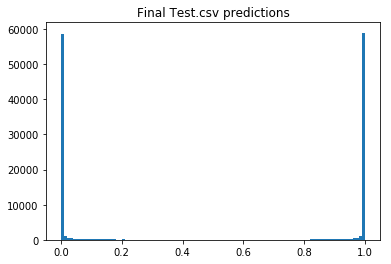

In [17]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = (2 * scores[0]['preds'] + 7000 * scores[1]['preds'] 
                 + 2 * scores[2]['preds'] + 7000 * scores[3]['preds']) / 14004
sub.to_csv('submission.csv',index=False)

import matplotlib.pyplot as plt
plt.hist(sub['target'],bins=100)
plt.title('Final Test.csv predictions')
plt.show()